In [91]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import json
import re # regular expression

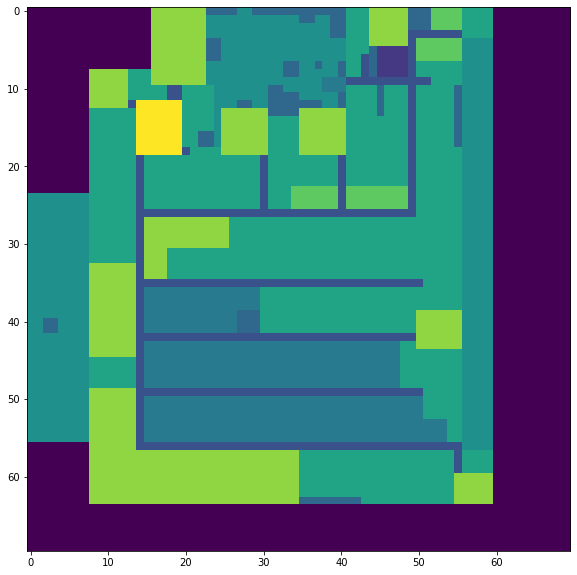

In [92]:
class Grid:
    def __init__(self, size):
        self.size = size # (x, y)
        self.rectangles = {} # {id: [x, y, length, height, "type"]}
        self.reset_all_cell_values()
        
    # Initialize the grid with a negative value
    def reset_all_cell_values(self):
        self.grid = np.array([[-2 for _ in range(self.size[1])] for _ in range(self.size[0])])

    # general iterator over rectangle
    def rectangle_iterator(self, rectangle, function):
        
        pass
    
    # Iterate through the dictionary self.rectangles and "draw" them on the grid
    def set_all_cell_values(self):
        for key in self.rectangles:
            x, y, l, h, type = self.rectangles[key]
            for i in range(x, x+l):
                for j in range(y, y+h):
                    self.set_single_cell_value(i,j,type)
    
    # Sets the same value in the grid for a given rectangle
    def set_cell_values_rectangle(self, rectangle):
        x, y, l, h, type = self.rectangles[rectangle.id]
        for i in range(x, x+l):
            for j in range(y, y+h):
                self.set_single_cell_value(i,j,type)
        
    # "draw" single square        
    def set_single_cell_value(self, x, y, value):
        self.grid[x, y] = value

    # retrieve type of certain square
    def get_cell_value(self, x, y):
        return self.grid[x][y]

    # actually draw grid
    def draw(self):
        plt.figure(figsize=(10,10))
        plt.imshow(self.grid)
        plt.show()
    
    # draw a new diagram with highlighted empty cells and returns their amount, CURRENTLY BREAKS THE GRID
    def highlight_empty(self):
        number_of_empty_cells = 0
        for i in range(self.size[0]):
            for j in range(self.size[1]):
                if self.get_cell_value(j,i) == 0:
                    number_of_empty_cells += 1
                    self.set_single_cell_value(j,i,100+j+i)
        self.draw()
        return number_of_empty_cells
    
    # add rectangle object to dictionary self.rectangles    
    def add_to_grid(self, rectangle):
        # check for overlaps
        x, y, l, h, value = rectangle.x, rectangle.y, rectangle.length, rectangle.height, rectangle.value
        for i in range(x, x+l):
            for j in range(y, y+h):
                if self.get_cell_value(i,j) > 0:
                    print("Error: Overlap")
        self.rectangles[rectangle.id] = [x, y, l, h, value]
        self.set_cell_values_rectangle(rectangle)
        
    # creates new dictionary for buildings in the city without streets
    def remove_streets_and_patches(self):
        self.buildings = {}
        for key in self.rectangles:
            if self.rectangles[key][4] > 1:
                self.buildings[key] = [self.rectangles[key]]

    # takes a city map json as input and executes all necessary methods to convert it to useful data
    def read_city_json(self, source_json:str):
        citymapdata = json.load(open(source_json, encoding="UTF-8")) # dict_keys(['CityMapData', 'CityEntities', 'UnlockedAreas']), len = 770, 1606, 205
        buildingType_keys = np.unique([entity["type"] for entity in citymapdata["CityEntities"].values()])
        """['clan_power_production' 'cultural_goods_production' 'culture'
        'decoration' 'diplomacy' 'friends_tavern' 'goods' 'greatbuilding'
        'hub_main' 'hub_part' 'impediment' 'main_building' 'military' 'off_grid'
        'outpost_ship' 'production' 'random_production' 'residential'
        'static_provider' 'street' 'tower']"""
        buildingType_values = [99,99,3,4,99,99,99,8,99,99,99,10,5,99,99,7,4,5,99,1,2] # 99 => off_grid or not used
        buildingType = dict(zip(buildingType_keys, buildingType_values))
        
        def _read_city_unlocked_areas(self):
            # reading CityMapData and creating grid with unlocked areas set to value "0"
            for patch in citymapdata["UnlockedAreas"]:
                patch.setdefault("y", 0)
                patch.setdefault("x", 0)
                self.add_to_grid(Rectangle(patch["y"], patch["x"], patch["width"], patch["length"], 0))
            
        def _read_city_entities(self):
            # reading CityMapData and creating a dictionary of currently available buildings
            for cityentity in citymapdata["CityEntities"].values():
                cityentity.setdefault("width", 0)
                cityentity.setdefault("length", 0)
            
        def _read_city_map_data(self):
            # reading CityMapData and adding each building to the grid
            for building in citymapdata["CityMapData"].values():
                building.setdefault("y", 0)
                building.setdefault("x", 0)
                buildingEntity = citymapdata["CityEntities"][building["cityentity_id"]]
                #print(buildingEntity)
                if re.match("W_MultiAge*", buildingEntity["id"]):
                    size = buildingEntity["components"]["AllAge"]["placement"]["size"]
                    width, length = size["x"], size["y"]
                else:
                    width, length = buildingEntity["width"], buildingEntity["length"]
                    
                if 0 <= building["y"] <= 70 and 0 <= building["x"] <= 70:
                    self.add_to_grid(Rectangle(building["y"], building["x"], length, width, buildingType[buildingEntity["type"]]))
                else: pass#print(building)
        
        _read_city_unlocked_areas(self)
        _read_city_entities(self)
        _read_city_map_data(self)
        
    # returns true if adjacent cell is a street
    def is_connected(self, rectangle, draw:bool=False):
        y, x, height, width = rectangle[:4] # e.g. [8, 13, 4, 3, 5]
        isConnected = False
        
        for i in range(height): # checking for streets on vertical edges
            if self.get_cell_value(y+i, x-1) == 1 or self.get_cell_value(y+i, x+width) == 1:
                isConnected = True
                break
            if draw:
                self.set_single_cell_value(y+i, x-1, 99)
                self.set_single_cell_value(y+i, x+width, 99)
         
        if not isConnected:            
            for j in range(width): # checking for streets on horizontal edges
                if self.get_cell_value(y-1, x+j) == 1 or self.get_cell_value(y+height, x+j) == 1:
                    isConnected = True
                    break
                if draw:
                    self.set_single_cell_value(y-1, x+j, 99)
                    self.set_single_cell_value(y+height, x+j, 99)
            
        return isConnected
                
class Rectangle:
    RECTANGLEID = 1
    
    def __init__(self, x:int=0, y:int=0, length:int=0, height:int=0, value:int=-1):
        self.x, self.y, self.length, self.height, self.value = x,y,length,height,value
        self.id = Rectangle.RECTANGLEID
        Rectangle.RECTANGLEID += 1            

# Create a new grid
grid = Grid((70,70))
grid.read_city_json("CityMapData.json")
grid.draw()